This notebook is used to predict missing Flux-data for Göttingen forest and the forst bothanical garden.  
The approach used is an MLP. Be careful to adjust how many cpu cores u want to use during training!

In [7]:
# important  imports
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import fastprogress

from sklearn.preprocessing import MinMaxScaler


In [8]:
# Get number of cpus to use for faster parallelized data loading
avb_cpus = os.cpu_count()

num_cpus = 4

print(avb_cpus, 'CPUs available,', num_cpus, 'were assigned' )

8 CPUs available, 4 were assigned


#  Utilites

In [9]:
############# UTILITIES ############

from modules.util import EBCDataset, grab_data, train_val_test_splitter, data_loaders, EarlyStopper

# Training Functions

In [20]:
############# TRAINING FUNCTIONS ###############

# Define validation metric
def prediction_error(y, y_pred): 
    #return abs(y - y_pred)
    return 0




def train(dataloader, optimizer, model, master_bar, loss_fn = nn.MSELoss()):
    """Run one training epoch.

    Args:
        dataloade: dataloader containing trainingdata
        optimizer: Torch optimizer object
        model: the model that is trained
        loss_fn: the loss function to be used -> nn.MSELoss()
        master_bar: Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        Mean epoch loss and accuracy
    """
    loss = []

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        # Reset optimmizers
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x)

        # Compute loss
        epoch_loss = loss_fn(y_pred, y)

        # Backward pass
        epoch_loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        loss.append(epoch_loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(loss)





def validate(dataloader, model, master_bar, loss_fn=nn.MSELoss()):
    """Compute loss and total prediction error on validation set.

    Args:
        dataloader: dataloader containing validation data
        model (nn.Module): the model to train
        loss_fn: the loss function to be used, defaults to MSELoss
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        Mean loss and total prediction error on validation set
    """
    epoch_loss = []

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x)

            # Compute loss
            loss = loss_fn(y_pred, y)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss)





def plot(title, label, train_results, val_results, yscale='linear', save_path=None):
    """Plot learning curves.

    Args:
        title: Title of plot
        label: y-axis label
        train_results: Vector containing training results over epochs
        val_results: vector containing validation results over epochs
        yscale: Defines how the y-axis scales
        save_path: Optional path for saving file
    """
    
    epochs = np.arange(len(train_results)) + 1
    
    sns.set(style='ticks')

    plt.plot(epochs, train_results, epochs, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(os.path.join( save_path , label+".png")), bbox_inches='tight')
    plt.show()




def run_training(model, optimizer, num_epochs, train_dataloader, val_dataloader, 
                 loss_fn=nn.MSELoss(), patience=1, early_stopper=None, scheduler=None, verbose=False):

    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses = [],[]
    
    if early_stopper:
        ES = EarlyStopper(patience = patience)

    # initialize old loss value varibale
    val_loss_old = 0
    
    for i,epoch in enumerate(master_bar):
        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, 
                                                 master_bar, loss_fn)
        # Validate the model
        epoch_val_loss = validate(val_dataloader, model, master_bar, loss_fn)
        
        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}')
            
        if early_stopper and i != 0:
            
            ES.check_criterion(epoch_val_loss, val_loss_old)
            if ES.early_stop:
                model = ES.load_checkpoint()
                break
        # Save biggest
        if early_stopper and epoch_val_loss > val_loss_old:
            val_loss_old = epoch_val_loss
            ES.save_model(model)
            
        if scheduler:
            scheduler.step()
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')

    plot("Loss", "Loss", train_losses, val_losses)
    return train_losses, val_losses

# The Multilayer Perceptron

In [21]:
from modules.models import MLP
from columns import COLS_FEATURES, COLS_LABELS, PATH

# The Training

In [22]:
# Collect data and create data loaders
# if COLS_METEO and COLS_FLUXES are changed make sure to run the preprocessing pipeline first
dataset, num_data, num_labels = grab_data('data/training_data_merged.csv', COLS_FEATURES, COLS_LABELS)

trainset, valset, testset = train_val_test_splitter(dataset)


# normalize features based on trainset statistics only
# trainset_mean = torch.mean(trainset.dataset.dataset.data, dim=0)
# trainset_std = torch.std(trainset.dataset.dataset.data, dim=0)

# trainset.dataset.dataset.data = (trainset.dataset.dataset.data - trainset_mean) / trainset_std ** 2
# valset.dataset.dataset.data = (valset.dataset.dataset.data - trainset_mean) / trainset_std ** 2
# testset.dataset.data = (trainset.dataset.dataset.data - trainset_mean) / trainset_std ** 2

labels_std = torch.std(trainset.dataset.dataset.labels, dim=0)
print(labels_std**2)

trainloader, valloader, testloader = data_loaders(trainset, valset, testset, num_cpus=num_cpus, batch_size=10)

tensor([7144.9404, 4185.6890])


In [23]:
# run single epoch with very low learning rate to check if initial loss is higher than label variance (it should be)
# Initialize the model
model = MLP(num_data, num_labels, num_hidden_units=30, num_hidden_layers=4)
# Set loss function and optimizer
criterion = nn.MSELoss()
lr = 10**(-5)
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 1

train_losses, val_losses = run_training(model, optimizer, num_epochs, trainloader, valloader, 
                 loss_fn=nn.MSELoss(), patience=1, early_stopper=None, scheduler=None, verbose=True)


Finished training after 6 seconds.


Train on larger timeframe.

Finished training after 535 seconds.


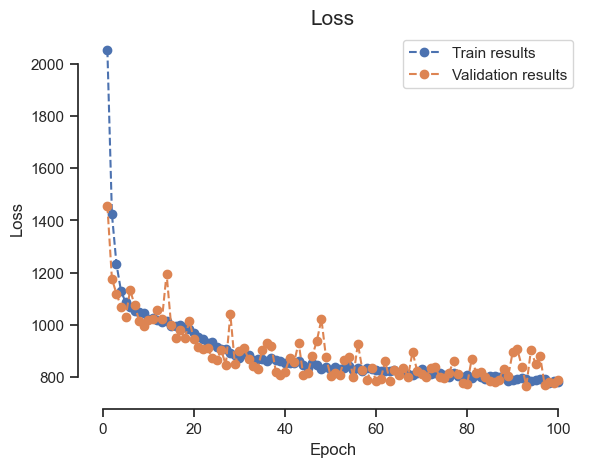

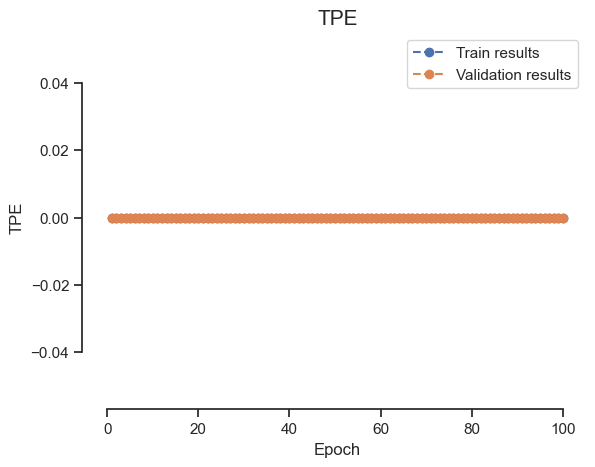

In [9]:
# Initialize the model
model = MLP(num_data, num_labels, num_hidden_units=30, num_hidden_layers=4)
# Set loss function and optimizer
criterion = nn.MSELoss()
lr = 10**(-3)
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 100

train_losses, val_losses, train_tpes, val_tpes = run_training(model, optimizer, num_epochs, trainloader, valloader, 
                                                              criterion, verbose=True)

In [65]:
# Save the model
torch.save(model.state_dict(), 'model_saves/mlp_1.pth' )